In [1]:
# dependencies
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

# setting the seeds
np.random.seed(0)
torch.manual_seed(0)


In [2]:
root_dir = '../dataset/Images' # where the data lies
device = 'cuda' if torch.cuda.is_available() else 'cpu' # the hardware device

print("The data we are working with lies in the following location: ")
print(root_dir)
print(f"We are using the device {device}")

The data we are working with lies in the following location: 
../dataset/Images
We are using the device cuda


In [3]:
# image transformations
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((128,128)),
        # Randomly augment the image data
        # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
        # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),


        # transforms.Resize((512,512)),
        # transforms.ToTensor(),
        # transforms.Normalize([0.458, 0.456, 0.406],
        #                      [0.229, 0.224, 0.225])

    ])


        # transforms.Resize((224, 224)), # resize each image to the size 224 * 224
        # transforms.ToTensor()          # convert image to pytorch tensors

}

In [4]:
natural_img_dataset = datasets.ImageFolder(
    root = root_dir,
    transform = image_transforms["train"]
)
print(natural_img_dataset)

# Dataset ImageFolder
#     Number of datapoints: 6899
#     Root location: /content/natural_images
#     StandardTransform
# Transform: Compose(
#                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
#                ToTensor()
#            )

Dataset ImageFolder
    Number of datapoints: 20580
    Root location: ../dataset/Images
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.3)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [5]:
# class to index mapping
print(natural_img_dataset.class_to_idx)


# index to class mapping : reverse of class to index mapping
idx_to_class = {v: k.split("-")[1] for k, v in natural_img_dataset.class_to_idx.items()}
print(idx_to_class)

{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n02093754-Border_terrier': 31, 'n02093859-Kerry_blue

In [6]:
def get_class_distribution(dataset):
    count_dict = {k.split("-")[1]:0 for k,v in natural_img_dataset.class_to_idx.items()} # initialise dictionary

    for input, label in dataset:
        label = idx_to_class[label]
        count_dict[label] += 1

    return count_dict

print("Distribution of classes: ", get_class_distribution(natural_img_dataset))


Distribution of classes:  {'Chihuahua': 152, 'Japanese_spaniel': 185, 'Maltese_dog': 252, 'Pekinese': 149, 'Shih': 214, 'Blenheim_spaniel': 188, 'papillon': 196, 'toy_terrier': 172, 'Rhodesian_ridgeback': 172, 'Afghan_hound': 239, 'basset': 175, 'beagle': 195, 'bloodhound': 187, 'bluetick': 171, 'black': 159, 'Walker_hound': 153, 'English_foxhound': 157, 'redbone': 148, 'borzoi': 151, 'Irish_wolfhound': 218, 'Italian_greyhound': 182, 'whippet': 187, 'Ibizan_hound': 188, 'Norwegian_elkhound': 196, 'otterhound': 151, 'Saluki': 200, 'Scottish_deerhound': 232, 'Weimaraner': 160, 'Staffordshire_bullterrier': 155, 'American_Staffordshire_terrier': 164, 'Bedlington_terrier': 182, 'Border_terrier': 172, 'Kerry_blue_terrier': 179, 'Irish_terrier': 169, 'Norfolk_terrier': 172, 'Norwich_terrier': 185, 'Yorkshire_terrier': 164, 'wire': 157, 'Lakeland_terrier': 197, 'Sealyham_terrier': 202, 'Airedale': 202, 'cairn': 197, 'Australian_terrier': 196, 'Dandie_Dinmont': 180, 'Boston_bull': 182, 'miniatu

In [7]:
# # visualise the  class distribution
# plt.figure(figsize=(20, 10))
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(natural_img_dataset)]).melt(),
#             x = "variable", y="value", hue="variable").set_title('Class Distribution of the natural_img_dataset')


In [8]:
print(len(natural_img_dataset)) # length of the dataset

20580


In [9]:
full_dataset = natural_img_dataset
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

# use torch.utils.data.random_split for training/test split
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [10]:
# train_dataset, val_dataset, test_dataset = random_split(natural_img_dataset, (18000, 2000, 580))
#
# print(len(train_dataset)) # length of the train division
# print(len(val_dataset)) # length of the validation division
# print(len(test_dataset)) # length of the test division

# 6899
# 5000
# 1000
# 899


In [11]:
train_loader = torch.utils.data.DataLoader(
train_dataset,
batch_size=50,
num_workers=0,
shuffle=False
)

# define a loader for the testing data we can iterate through in 50-image batches
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=50,
    num_workers=0,
    shuffle=False
)

In [12]:
def load_dataset(data_path, batch_size):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
        # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
        # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )


    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    VALID_RATIO = 0.9

    n_train_examples = int(len(train_size) * VALID_RATIO)
    n_valid_examples = len(train_size) - n_train_examples
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size, n_valid_examples])

    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )

    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )

    val_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader, val_loader

    # Length of the train_loader: 78
    # Length of the val_loader: 16
# Length of the test_loader: 15


In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3), # inp (3, 512, 512)
            nn.Conv2d(8, 16, 3),
            nn.MaxPool2d(2),
            nn.ReLU() # op (16, 256, 256)
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(16, 32, 5), # inp (16, 256, 256)
            nn.Conv2d(32, 32, 3),
            nn.MaxPool2d(4),
            nn.ReLU() # op (32, 64, 64)
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # inp (32, 64, 64)
            nn.Conv2d(64, 64, 5),
            nn.MaxPool2d(2),
            nn.ReLU() # op (64, 32, 32)
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(64, 128, 5), # inp (64, 32, 32)
            nn.Conv2d(128, 128, 3),
            nn.MaxPool2d(2),
            nn.ReLU() # op (128, 16, 16)
        )
        self.Lin1 = nn.Linear(15488, 120)
        self.Lin2 = nn.Linear(1500, 150)
        self.Lin3 = nn.Linear(150, 120)


    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0), -1)
        x = self.Lin1(x)


        return F.log_softmax(x, dim = 1)

model = Net()

In [14]:

# model = torch.load('800ephsapparel')
# model = model.train()
# is_cuda = check_cuda()
# if is_cuda:
# model.cuda()

#optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
# for epoch in tqdm(range(20)):  # loop over the dataset multiple times
#
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#
#         inputs, labels = data
#         inputs, labels = inputs.cuda(), labels.cuda()
#         # zero the parameter gradients
#         optimizer.zero_grad()
#
#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#
#         # print statistics
#         running_loss += loss.item()
#     if i % 10 == 0:    # print every 10 mini-batches
#        print('[%d, %5d] loss: %.3f' %
#             (epoch + 1, i + 1, running_loss / 2000))
#     #  running_loss = 0.0
#
# print('Finished Training')

In [15]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in val_loader:
#         images, labels = data
#         images, labels = images.cuda(), labels.cuda()
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#
# print('Accuracy of the network on the test images: %d %%' % (
#         100 * correct / total))

In [16]:
# # prepare to count predictions for each class
# correct_pred = {classname: 0 for classname, v in natural_img_dataset.class_to_idx.items()}
# total_pred = {classname: 0 for classname, v in natural_img_dataset.class_to_idx.items()}
#
# # again no gradients needed
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = model(images)
#         _, predictions = torch.max(outputs, 1)
#         # collect the correct predictions for each class
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1
#
#
# # print accuracy for each class
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [17]:
# Create a neural net class
class Net_dog(nn.Module):


    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net_dog, self).__init__()

        # In the init function, we define each layer we will use in our model

        # Our images are RGB, so we have input channels = 3.
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)

        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)

        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them

        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function

        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))

        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))

        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)

        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function
        return torch.log_softmax(x, dim=1)

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net_dog(num_classes=len(idx_to_class)).to(device)

print(model)

Net_dog(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=120, bias=True)
)


In [18]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [19]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # return average loss for the epoch
    return avg_loss

In [ ]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 50
print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Training on cuda
Epoch: 1
	Training batch 1 Loss: 4.789412
	Training batch 2 Loss: 19.064537
	Training batch 3 Loss: 8.832406
	Training batch 4 Loss: 5.200384
	Training batch 5 Loss: 4.752981
	Training batch 6 Loss: 4.806049
	Training batch 7 Loss: 4.785721
	Training batch 8 Loss: 4.784298
	Training batch 9 Loss: 4.789526
	Training batch 10 Loss: 4.790889
	Training batch 11 Loss: 4.786873
	Training batch 12 Loss: 4.797189
	Training batch 13 Loss: 4.793830
	Training batch 14 Loss: 4.789069
	Training batch 15 Loss: 4.782050
	Training batch 16 Loss: 4.786142
	Training batch 17 Loss: 4.789464
	Training batch 18 Loss: 4.784107
	Training batch 19 Loss: 4.784783
	Training batch 20 Loss: 4.788156
	Training batch 21 Loss: 4.788984
	Training batch 22 Loss: 4.786483
	Training batch 23 Loss: 4.801865
	Training batch 24 Loss: 4.776061
	Training batch 25 Loss: 4.788981
	Training batch 26 Loss: 4.777503
	Training batch 27 Loss: 4.788393
	Training batch 28 Loss: 4.789334
	Training batch 29 Loss: 4.796

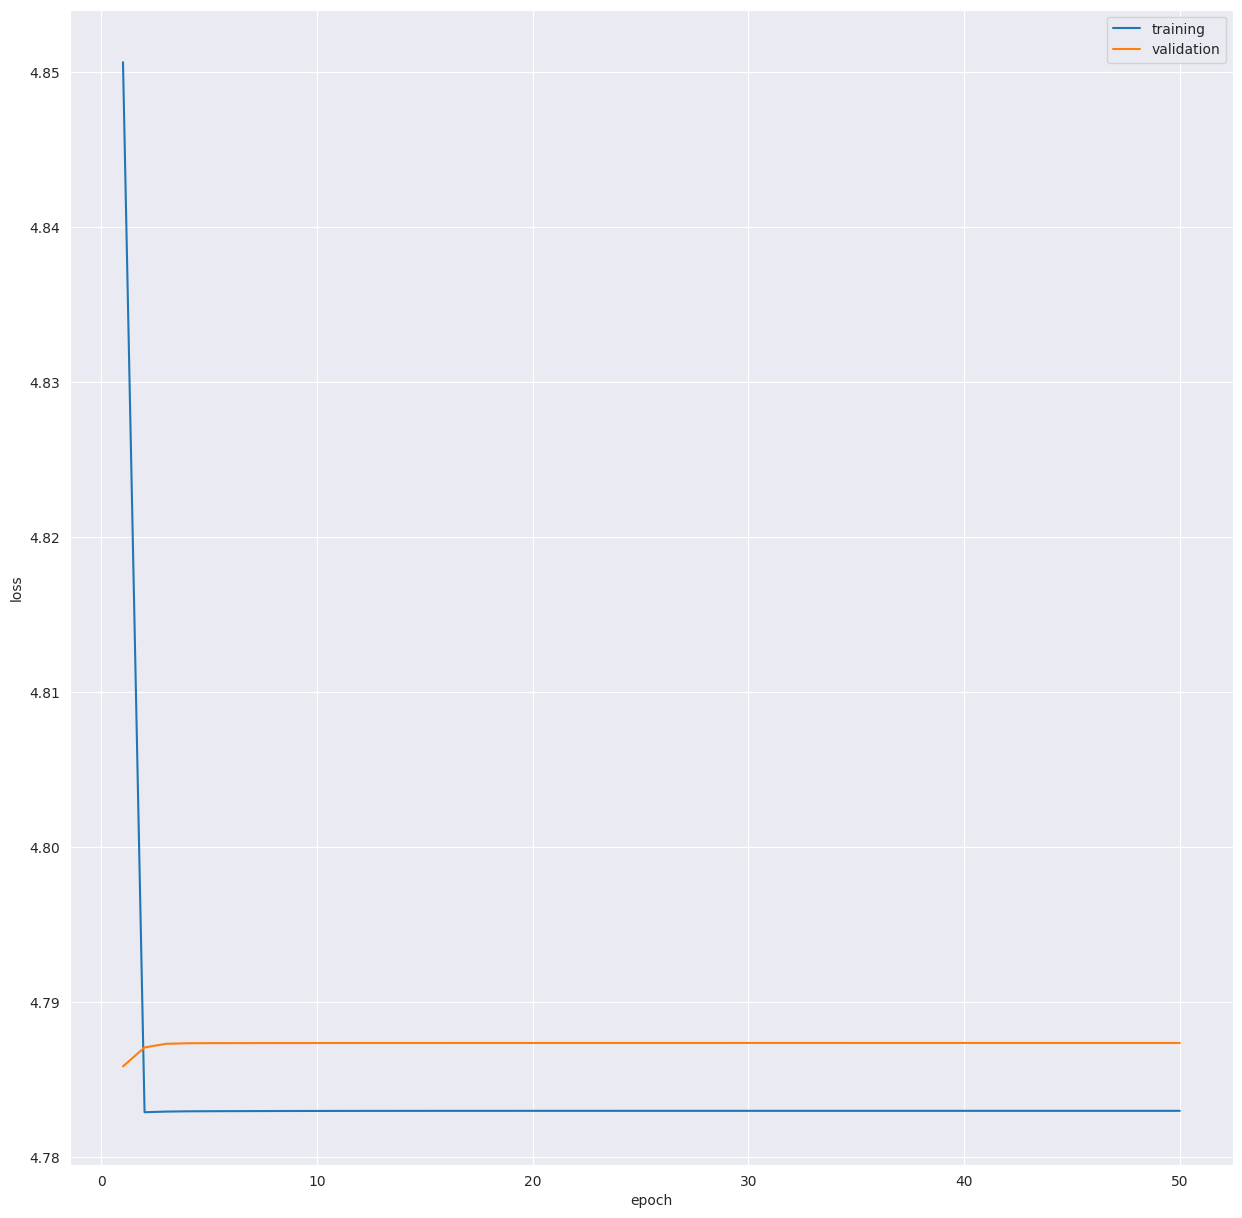

In [24]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...
6175


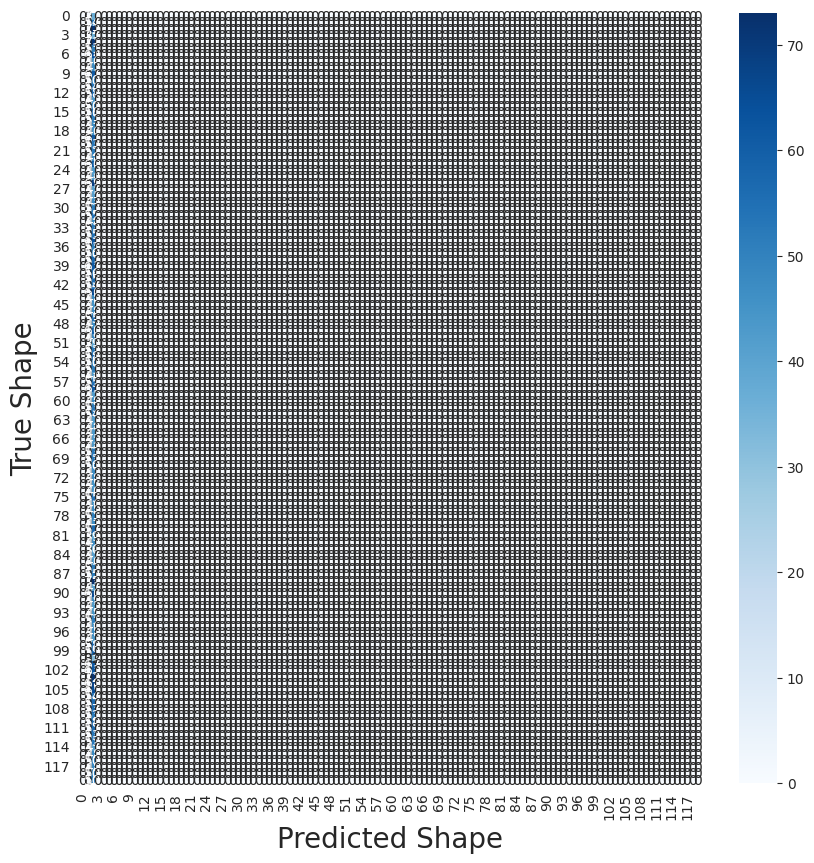

In [25]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data.to(device)).data.cpu().numpy().argmax(1):
        predictions.append(prediction)
print(len(truelabels))
    # Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
# tick_marks = np.arange(len(idx_to_class))

df_cm = pd.DataFrame(cm)#,  columns = [v for k,v in idx_to_class.items()])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

In [26]:
idx_to_class

{0: 'Chihuahua',
 1: 'Japanese_spaniel',
 2: 'Maltese_dog',
 3: 'Pekinese',
 4: 'Shih',
 5: 'Blenheim_spaniel',
 6: 'papillon',
 7: 'toy_terrier',
 8: 'Rhodesian_ridgeback',
 9: 'Afghan_hound',
 10: 'basset',
 11: 'beagle',
 12: 'bloodhound',
 13: 'bluetick',
 14: 'black',
 15: 'Walker_hound',
 16: 'English_foxhound',
 17: 'redbone',
 18: 'borzoi',
 19: 'Irish_wolfhound',
 20: 'Italian_greyhound',
 21: 'whippet',
 22: 'Ibizan_hound',
 23: 'Norwegian_elkhound',
 24: 'otterhound',
 25: 'Saluki',
 26: 'Scottish_deerhound',
 27: 'Weimaraner',
 28: 'Staffordshire_bullterrier',
 29: 'American_Staffordshire_terrier',
 30: 'Bedlington_terrier',
 31: 'Border_terrier',
 32: 'Kerry_blue_terrier',
 33: 'Irish_terrier',
 34: 'Norfolk_terrier',
 35: 'Norwich_terrier',
 36: 'Yorkshire_terrier',
 37: 'wire',
 38: 'Lakeland_terrier',
 39: 'Sealyham_terrier',
 40: 'Airedale',
 41: 'cairn',
 42: 'Australian_terrier',
 43: 'Dandie_Dinmont',
 44: 'Boston_bull',
 45: 'miniature_schnauzer',
 46: 'giant_schna